In [1]:
import os
import mne
import json

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.signal import welch
import networkx as nx
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix

# 1. Import datasets

In [2]:
'''
read_json_dicts: read a .json file
input:
    * file_path: the path to the .json file
output:
    * file: a pd.DataFrame
'''
def read_json_dicts (file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data_dict = json.load(f)
    return pd.DataFrame(data_dict)

'''
collect_eeg_data: read all .set files in a folder
input:
    * folder_path: the path of the folder
output: 
    * data: a dictionary, with file names as keys, and numpy array in each .set file as value 
'''
def collect_eeg_data(folder_path):
    data = {}
    for filename in os.listdir(folder_path):
        if filename.endswith(".set"):
            file_path = os.path.join(folder_path, filename)
            raw = mne.io.read_raw_eeglab(file_path, preload=True)
            data[filename] = raw.get_data()

    return data

# 2. Analysis data, extract features

In [3]:
# general entropy
def spectral_entropy(psd, eps=1e-12):
    psd_norm = psd / (np.sum(psd) + eps)
    return -np.sum(psd_norm * np.log(psd_norm + eps)) / np.log(len(psd_norm))

# network_metrics
def compute_network_metrics(eeg_data_segment, threshold=0.5):
    # calculate the correlation
    corr_matrix = np.corrcoef(eeg_data_segment)
    np.fill_diagonal(corr_matrix, 0)

    # generate the graph
    binary_matrix = (np.abs(corr_matrix) >= threshold).astype(int)
    G = nx.from_numpy_array(binary_matrix)
    
    # Average clustering coefficient
    avg_clustering = nx.average_clustering(G)
    
    # characteristic path length
    if nx.is_connected(G):
        char_path_length = nx.average_shortest_path_length(G)
    else:
        largest_cc = max(nx.connected_components(G), key=len)
        subG = G.subgraph(largest_cc)
        char_path_length = nx.average_shortest_path_length(subG)

    # small world degree
    density = nx.density(G)
    Crand = density 
    degrees = [d for n, d in G.degree()]
    avg_degree = np.mean(degrees) if degrees else 0
    if avg_degree > 1:
        Lrand = np.log(G.number_of_nodes()) / np.log(avg_degree)
    else:
        Lrand = char_path_length
    small_worldness = (avg_clustering / (Crand + 1e-10)) / ((char_path_length / (Lrand + 1e-10)) + 1e-10)
    
    return avg_clustering, char_path_length, small_worldness

'''
extract_features_for_one_segment: extract features from a brain-wave as numpy array
input:
    * eeg_data_segment: a 2D numpy array containing a patient's brain wave:
        - column: outputs from diff electrodes at the same time
        - row: outputs from the same electrode at diff times
output:
    * feature_vector: a (, 131) array containing following featrures:
        - alpha ~ gamma indexes (5)
        - alpha ~ gamma power (5)
        - peak frequencies
        - spectral entropy
        - network indexes
'''

def extract_features(eeg_data_segment, fs=250):
    n_channels = eeg_data_segment.shape[0]
    
    # 1. Welch PSD
    freqs, psd = welch(eeg_data_segment, fs=fs, axis=1, nperseg=256)
    
    # define the range
    delta_idx = np.where((freqs >= 1) & (freqs < 4))[0]
    theta_idx = np.where((freqs >= 4) & (freqs < 8))[0]
    alpha_idx = np.where((freqs >= 8) & (freqs <= 12))[0]
    beta_idx  = np.where((freqs >= 13) & (freqs <= 30))[0]
    gamma_idx = np.where((freqs >= 30) & (freqs <= 50))[0]
    
    # calculate the power
    delta_power = np.mean(psd[:, delta_idx], axis=1)
    theta_power = np.mean(psd[:, theta_idx], axis=1)
    alpha_power = np.mean(psd[:, alpha_idx], axis=1)
    beta_power  = np.mean(psd[:, beta_idx], axis=1)
    gamma_power = np.mean(psd[:, gamma_idx], axis=1)
    
    # 2. Peak
    def peak_frequency(psd_band, freqs_band):
        peak_idx = np.argmax(psd_band, axis=1)
        return freqs_band[peak_idx]
    
    alpha_peak = peak_frequency(psd[:, alpha_idx], freqs[alpha_idx])
    beta_peak  = peak_frequency(psd[:, beta_idx], freqs[beta_idx])
    
    # 3. General entropy
    spectral_entropies = np.array([spectral_entropy(psd[i, :]) for i in range(n_channels)])
    mean_spectral_entropy = np.mean(spectral_entropies)
    
    # 4. Network indexes
    avg_clustering, char_path_length, small_worldness = compute_network_metrics(eeg_data_segment, threshold=0.5)
    
    # 5. Concatenate features
    feature_vector = np.concatenate([
        delta_power, theta_power, alpha_power, beta_power, gamma_power,
        alpha_peak, beta_peak,
        np.array([mean_spectral_entropy]),
        np.array([avg_clustering, char_path_length, small_worldness])
    ]).flatten()
    
    return feature_vector

# 3. Prepare the data

In [4]:
"""
Performs GridSearchCV hyperparameter search for SVM, KNN, Decision Tree, and Random Forest.
Prints the best parameters and CV accuracy for each model and returns the best performing model.
"""
# def optimal_model(X_train, y_train):
#     model = RandomForestClassifier()
#     models_params = {
#         'estimator': RandomForestClassifier(random_state=42),
#         'param_grid': {
#             'n_estimators': [50, 100, 200],
#             'max_depth': [None, 5, 10, 20],
#             'min_samples_split': [2, 5, 10]
#         }
#     }
    
#     grid_search = GridSearchCV(
#         estimator=model,
#         param_grid=models_params['param_grid'],
#         cv=5,
#         scoring='accuracy',
#         n_jobs=-1
#     )
#     grid_search.fit(X_train, y_train)
#     best_model = grid_search.best_estimator_
#     return best_model


def tune_random_forest(X_train, y_train, X_test, y_test):
    """
    Tune RandomForestClassifier using GridSearchCV and print best parameters and test accuracy.
    """
    pipeline = Pipeline([
        ('classifier', RandomForestClassifier(random_state=42))
    ])
    
    param_grid = {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 5, 10, 20],
        'classifier__min_samples_split': [2, 5, 10]
    }
    
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    
    print("Best Parameters for RandomForestClassifier:", grid_search.best_params_)
    test_accuracy = grid_search.score(X_test, y_test)
    print("Test Accuracy for RandomForestClassifier: {:.4f}\n".format(test_accuracy))
    
    return grid_search.best_estimator_

def tune_svc(X_train, y_train, X_test, y_test):
    """
    Tune SVC using GridSearchCV and print best parameters and test accuracy.
    """
    pipeline = Pipeline([
        ('classifier', SVC())
    ])
    
    param_grid = {
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['linear', 'rbf'],
        'classifier__gamma': ['scale', 'auto']
    }
    
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    
    print("Best Parameters for SVC:", grid_search.best_params_)
    test_accuracy = grid_search.score(X_test, y_test)
    print("Test Accuracy for SVC: {:.4f}\n".format(test_accuracy))
    
    return grid_search.best_estimator_

def tune_gaussian_nb(X_train, y_train, X_test, y_test):
    """
    Tune GaussianNB using GridSearchCV.
    GaussianNB typically does not have hyperparameters to tune,
    so we simply compare the model performance.
    """
    pipeline = Pipeline([
        ('classifier', GaussianNB())
    ])
    
    # Empty parameter grid as GaussianNB has no hyperparameter to tune
    param_grid = {}
    
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    
    print("Best Parameters for GaussianNB:", grid_search.best_params_)
    test_accuracy = grid_search.score(X_test, y_test)
    print("Test Accuracy for GaussianNB: {:.4f}\n".format(test_accuracy))
    
    return grid_search.best_estimator_

def tune_gradient_boosting(X_train, y_train, X_test, y_test):
    """
    Tune GradientBoostingClassifier using GridSearchCV and print best parameters and test accuracy.
    """
    pipeline = Pipeline([
        ('classifier', GradientBoostingClassifier(random_state=42))
    ])
    
    param_grid = {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.01, 0.1, 1.0],
        'classifier__max_depth': [3, 5, 7]
    }
    
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    
    print("Best Parameters for GradientBoostingClassifier:", grid_search.best_params_)
    test_accuracy = grid_search.score(X_test, y_test)
    print("Test Accuracy for GradientBoostingClassifier: {:.4f}\n".format(test_accuracy))
    
    return grid_search.best_estimator_

In [5]:
# evaluation
def plot_model_evaluation(model, X_test, y_test):
    """
    Plots the ROC curve, Precision-Recall (PR) curve, and Confusion Matrix for the provided model.
    Supports both binary and multiclass classification using a one-vs-rest approach.
    
    Parameters:
        model: Trained classifier with either 'predict_proba' or 'decision_function' method.
        X_test: Test feature data.
        y_test: True labels for the test set.
    """
    # Determine the unique classes
    classes = np.unique(y_test)
    n_classes = len(classes)
    
    # Obtain prediction scores.
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)
    elif hasattr(model, "decision_function"):
        y_scores = model.decision_function(X_test)
        if n_classes == 2 and y_scores.ndim == 1:
            # For binary classification, convert decision_function output to two-column array.
            y_scores = np.vstack([1 - y_scores, y_scores]).T
    else:
        raise ValueError("Model does not have predict_proba or decision_function method")
        
    # Binary classification case
    if n_classes == 2:
        # Use probabilities for the positive class.
        y_score = y_scores[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        
        precision, recall, _ = precision_recall_curve(y_test, y_score)
        avg_precision = average_precision_score(y_test, y_score)
        
        # Compute confusion matrix using threshold 0.5
        y_pred = (y_score >= 0.5).astype(int)
        cm = confusion_matrix(y_test, y_pred)
        
        # Plot ROC, PR, and Confusion Matrix side by side
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # ROC Curve
        axes[0].plot(fpr, tpr, color='darkorange', lw=2,
                     label=f'ROC (AUC = {roc_auc:.2f})')
        axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axes[0].set_xlim([0.0, 1.0])
        axes[0].set_ylim([0.0, 1.05])
        axes[0].set_xlabel('False Positive Rate')
        axes[0].set_ylabel('True Positive Rate')
        axes[0].set_title('ROC Curve')
        axes[0].legend(loc="lower right")
        
        # PR Curve
        axes[1].plot(recall, precision, color='blue', lw=2,
                     label=f'PR (AP = {avg_precision:.2f})')
        axes[1].set_xlim([0.0, 1.0])
        axes[1].set_ylim([0.0, 1.05])
        axes[1].set_xlabel('Recall')
        axes[1].set_ylabel('Precision')
        axes[1].set_title('Precision-Recall Curve')
        axes[1].legend(loc="lower left")
        
        # Confusion Matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[2])
        axes[2].set_xlabel('Predicted Label')
        axes[2].set_ylabel('True Label')
        axes[2].set_title('Confusion Matrix')
        
        plt.tight_layout()
        plt.show()
        
    else:
        # Multiclass case: Use one-vs-rest approach.
        y_test_binarized = label_binarize(y_test, classes=classes)
        
        # Dictionaries to hold metrics for each class.
        fpr, tpr, roc_auc = {}, {}, {}
        precision, recall, avg_precision = {}, {}, {}
        
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_scores[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            precision[i], recall[i], _ = precision_recall_curve(y_test_binarized[:, i], y_scores[:, i])
            avg_precision[i] = average_precision_score(y_test_binarized[:, i], y_scores[:, i])
        
        # Also compute micro-average ROC and PR curves.
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_scores.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_binarized.ravel(), y_scores.ravel())
        avg_precision["micro"] = average_precision_score(y_test_binarized, y_scores, average="micro")
        
        # Compute overall confusion matrix.
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        
        # Plot ROC curves for each class.
        plt.figure(figsize=(8, 6))
        for i in range(n_classes):
            plt.plot(fpr[i], tpr[i], lw=2,
                     label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves (One-vs-Rest)')
        plt.legend(loc="lower right")
        plt.show()
        
        # Plot Precision-Recall curves for each class.
        plt.figure(figsize=(8, 6))
        for i in range(n_classes):
            plt.plot(recall[i], precision[i], lw=2,
                     label=f'Class {classes[i]} (AP = {avg_precision[i]:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curves (One-vs-Rest)')
        plt.legend(loc="lower left")
        plt.show()
        
        # Plot overall Confusion Matrix.
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.show()


# 4. Run

## 1) Import datasets

In [6]:
folder_path_1 = r'raw_data\train'
folder_path_2 = r'raw_data\test'
file_path_labels = r'raw_data\labels.json'

data_original_train = collect_eeg_data(folder_path_1)
data_original_test = collect_eeg_data(folder_path_2)
data_labels = read_json_dicts (file_path_labels)

data_labels.set_index('file_name', inplace=True)

C:\Users\27298\AppData\Local\Temp\ipykernel_11136\1895958936.py:25: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)
C:\Users\27298\AppData\Local\Temp\ipykernel_11136\1895958936.py:25: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)
C:\Users\27298\AppData\Local\Temp\ipykernel_11136\1895958936.py:25: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)
C:\Users\27298\AppData\Local\Temp\ipykernel_11136\1895958936.py:25: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)
C:\Users\27298\AppData\Local\Temp\ipykernel_11136\1895958936.py:25: Runtim

In [7]:
# Loop over the training data dictionary keys
for key in data_original_train:
    scaler = StandardScaler()
    # Fit and transform the training data for this key
    data_original_train[key] = scaler.fit_transform(data_original_train[key])
    print(f"Standardized training data for key '{key}'")

# Loop over the testing data dictionary keys
for key in data_original_test:
    scaler = StandardScaler()
    # Fit and transform the testing data for this key
    data_original_test[key] = scaler.fit_transform(data_original_test[key])
    print(f"Standardized testing data for key '{key}'")

Standardized training data for key 'sub-001_eeg_chunk_1.set'
Standardized training data for key 'sub-001_eeg_chunk_10.set'
Standardized training data for key 'sub-001_eeg_chunk_11.set'
Standardized training data for key 'sub-001_eeg_chunk_12.set'
Standardized training data for key 'sub-001_eeg_chunk_13.set'
Standardized training data for key 'sub-001_eeg_chunk_14.set'
Standardized training data for key 'sub-001_eeg_chunk_15.set'
Standardized training data for key 'sub-001_eeg_chunk_16.set'
Standardized training data for key 'sub-001_eeg_chunk_17.set'
Standardized training data for key 'sub-001_eeg_chunk_18.set'
Standardized training data for key 'sub-001_eeg_chunk_19.set'
Standardized training data for key 'sub-001_eeg_chunk_2.set'
Standardized training data for key 'sub-001_eeg_chunk_20.set'
Standardized training data for key 'sub-001_eeg_chunk_21.set'
Standardized training data for key 'sub-001_eeg_chunk_22.set'
Standardized training data for key 'sub-001_eeg_chunk_24.set'
Standardiz

In [8]:
# split the train / test labels
train_data_labels = data_labels[data_labels.index.str.startswith('train')]
test_data_labels = data_labels[data_labels.index.str.startswith('test')]

label_train = train_data_labels['label']
label_test = test_data_labels['label']

label_train.index = [i.replace('train/', '') for i in label_train.index]
label_test.index = [i.replace('test/', '') for i in label_test.index]

In [9]:
train_set = pd.merge(pd.Series(data_original_train, dtype=object, name='features'), label_train, how='left', left_index=True, right_index=True)
train_set = train_set.sample(frac=1, random_state=42)
test_set = pd.merge(pd.Series(data_original_test, dtype=object, name='features'), label_test, how='left', left_index=True, right_index=True)

## 2) Decrease dimensions of data

In [10]:
# split into train / test sets
X_train = np.array([extract_features(data) for data in train_set['features']])   # (3219, 137)
X_test = np.array([extract_features(data) for data in test_set['features']])   # (1217, 137)

y_train = np.array([label for label in train_set['label']])
y_test = np.array([label for label in test_set['label']])

# encode str into int
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

## 3) Run SVM

### A. find the optimal model & parameters

In [11]:
gaussian_nb = tune_gaussian_nb(X_train, y_train, X_test, y_test)

Best Parameters for GaussianNB: {}
Test Accuracy for GaussianNB: 0.5933



In [12]:
random_forest = tune_random_forest(X_train, y_train, X_test, y_test)

Best Parameters for RandomForestClassifier: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Test Accuracy for RandomForestClassifier: 0.7453



In [13]:
svc = tune_svc(X_train, y_train, X_test, y_test)

Best Parameters for SVC: {'classifier__C': 10, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}
Test Accuracy for SVC: 0.6910



In [14]:
gradient_boosting = tune_gradient_boosting(X_train, y_train, X_test, y_test)

Best Parameters for GradientBoostingClassifier: {'classifier__learning_rate': 1.0, 'classifier__max_depth': 3, 'classifier__n_estimators': 200}
Test Accuracy for GradientBoostingClassifier: 0.7724



### B. further evaluation on the optimal model

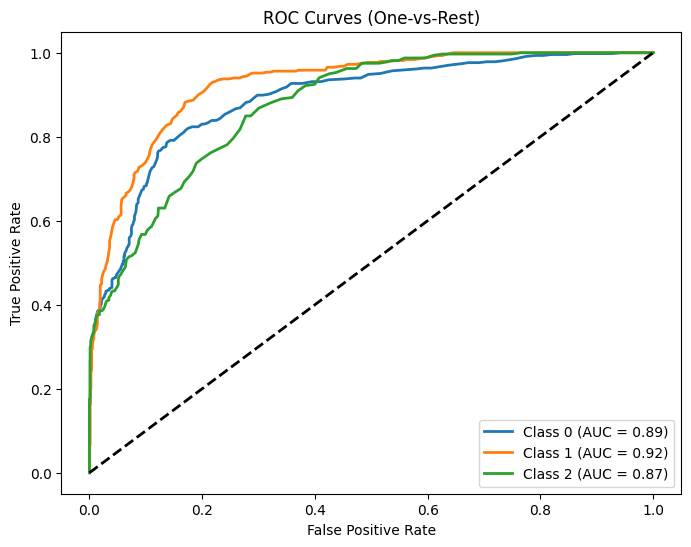

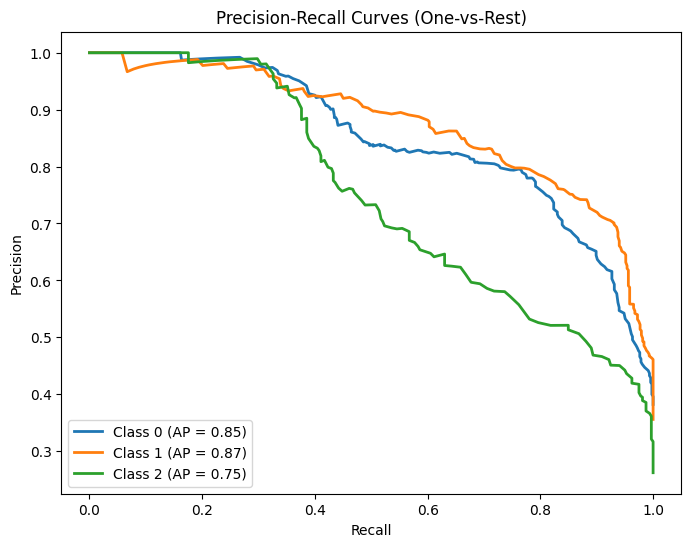

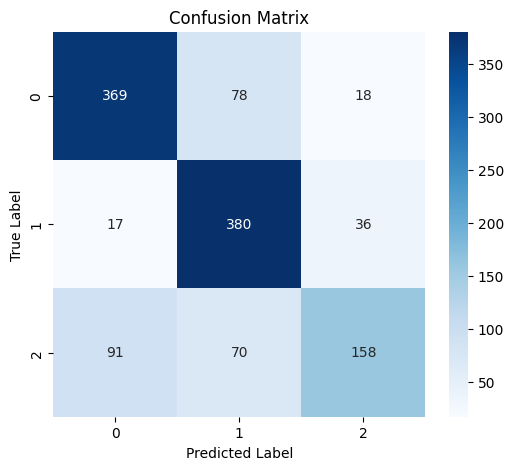

In [16]:
plot_model_evaluation(random_forest, X_test, y_test)